In [1]:
'''
Instructions to run on collab:
1. Upload the training and test files inside the /directory
2. If you already have a model then only run the model load and demo part of the code
3. To upload a model, upload it in content/ directory on collab
'''
import os
import pandas as pd


def load_dataset(name, index_name):
    file_path = f"/{name}.csv"
    df = pd.read_csv(file_path, parse_dates=True, index_col=index_name)
    return df.dropna()
# Load datasets
NASDAQ_TRAIN = load_dataset("train", "Date")
NASDAQ_TEST = load_dataset("test", "Date")

FileNotFoundError: ignored

In [ ]:
class Account:
    # Properties (public)
    holdings: int
    average_price: float
    available_funds: float
    deposited_funds: float
    goal: float
    stop_loss_limit: float

    # Constructor
    def __init__(self, start: float, goal: float, stop_lost_limit: float):
        self.goal = goal
        self.available_funds = start
        self.deposited_funds = start
        self.stop_loss_limit = stop_lost_limit

        self.profit = 0
        self.average_price = 0
        self.holdings = 0

    # Methods
    def calculate_profit(self, current_stock_price: float):
        return round(
            (self.get_total_value(current_stock_price) - self.deposited_funds)
            / self.deposited_funds,
            4,
        )

    def should_exit(self, current_stock_price: float):
        return (
            self.should_trigger_stop_loss(current_stock_price)
            or self.get_total_value(current_stock_price) >= self.goal
        )

    def should_trigger_stop_loss(self, current_stock_price: float):
        return self.get_total_value(current_stock_price) <= self.stop_loss_limit

    def get_total_value(self, current_stock_price: float):
        return self.holdings * current_stock_price + self.available_funds

    def update_holding(self, holding_change: int, fulfilled_price: float):
        # Buy
        if holding_change > 0:
            total_cost = holding_change * fulfilled_price
            new_total_holding_value = (self.holdings * self.average_price) + total_cost
            self.holdings += holding_change
            self.average_price = new_total_holding_value / self.holdings
            self.available_funds -= total_cost

        # Sell
        elif holding_change < 0:
            self.available_funds += abs(holding_change) * fulfilled_price
            self.holdings += holding_change  # holding_change is negative

    def reset(self):
        self.profit = 0
        self.average_price = 0
        self.holdings = 0
        self.available_funds = self.deposited_funds


In [4]:
import math
from enum import Enum

import numpy as np
class ActionType(Enum):
    Sell = -1
    Hold = 0
    Buy = 1

    def __eq__(self, __value: object) -> bool:
        return self.value == __value

class Action:
    @staticmethod
    def get_action_type (action: int) -> ActionType:
        if action > 0:
            return ActionType.Buy

        if action < 0:
            return ActionType.Sell

        return ActionType.Hold

    @staticmethod
    def get_action_mask (env: 'TradingEnv') -> np.ndarray:
        trading_env: 'TradingEnv' = env.unwrapped
        account: Account = trading_env.account
        stock_price: float = trading_env.prices[trading_env._current_tick]

        limit = trading_env.max_shares_per_trade
        low = -account.holdings
        high = math.floor(account.available_funds / stock_price)

        mask = [1 if (value >= low and value <= high) else 0 for value in range(-limit, limit + 1)]
        return np.array(mask, dtype=np.int8)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
!pip install gymnasium
import gymnasium as gym
import pandas as pd
from typing import List, Dict
import time


class TradingEnv(gym.Env):
    # Properties (public)
    render_mode: str
    prices: float
    data_frames: pd.DataFrame
    window_size: int
    shape: tuple[int, int]
    max_shares_per_trade: int

    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Box

    account: Account
    history: Dict[str, List[float] | Dict]

    metadata = {"render_modes": ["human"], "render_fps": 4}

    # Properties (private)
    _start_tick: int
    _end_tick: int
    _current_tick: int = None
    _last_trade_tick: int = None
    _total_reward: float
    _total_profit: float
    _fig: plt.Figure
    _graphs: List[plt.Axes]

    # Constructor
    def __init__(
        self,
        data_frames: pd.DataFrame,
        window_size: int,
        render_mode: str = None,
        start: float = 0,
        goal: float = 0,
        stop_loss_limit: float = 0,
        max_shares_per_trade: int = 10,
    ):
        self.account = Account(start, goal, stop_loss_limit)

        self.render_mode = render_mode

        self.data_frames = data_frames
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])
        self.max_shares_per_trade = max_shares_per_trade

        # spaces
        self.observation_space = gym.spaces.Box(
            low=-1e10, high=1e10, shape=self.shape, dtype=np.float32
        )

        self.action_space = gym.spaces.Discrete(
            2 * self.max_shares_per_trade + 1, start=-self.max_shares_per_trade
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._total_reward = None

        self.history = {}

    # Business logics
    def _process_data(self):
        prices = self.data_frames.loc[:, "Close"].to_numpy()

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices.astype(np.float32), signal_features.astype(np.float32)

    def _update_history(self, info: dict[str, float], action):
        type = Action.get_action_type(action)

        self.history.setdefault("actions", {})
        self.history["actions"].update({self._current_tick: type})

        for key, value in info.items():
            self.history.setdefault(key, [])
            self.history[key].append(value)

        self.history["account_total"].append(
            self.account.get_total_value(self.prices[self._current_tick])
        )

        self.history.setdefault("shares", [])
        self.history["shares"].append(self.account.holdings)
    def _fulfill_order(self, action):
        previous_price = self.prices[self._current_tick - 1]
        current_price = self.prices[self._current_tick]
        order_quantity = action
        available_funds = self.account.available_funds
        current_holding = self.account.holdings

        if (action > 0 and order_quantity * current_price <= available_funds) or (
            action < 0 and order_quantity <= current_holding
        ):
            self.account.update_holding(action, current_price)
            self._last_trade_tick = self._current_tick

        delta = self.account.get_total_value(current_price) - self.account.get_total_value(
            previous_price
        )

        return delta

    # Lifecycle
    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)

        if seed is not None:
            self.action_space.seed(seed)
        else:
            self.action_space.seed(int(time.time()))

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._total_reward = 0
        self._total_profit = 0
        self.account.reset()
        self.history = {
            "reward": [0.0],
            "profit": [0.0],
            "actions": {},
            "account_total": [self.account.available_funds],
            "shares": [0],
        }

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == "human":
            self.render()
        return observation, info

    def step(self, action):
        self._truncated = False
        self._current_tick += self.window_size

        if self._current_tick > self._end_tick:
            self._current_tick = self._end_tick

        step_reward = 0
        current_stock_price = self.prices[self._current_tick]

        if self._current_tick == self._end_tick:
            self._truncated = True
            self._current_tick = self._end_tick
            step_reward = self._fulfill_order(-self.account.holdings)

        elif self.account.should_exit(current_stock_price):
            self._truncated = True
            self._end_tick = self._current_tick
            step_reward = self._fulfill_order(-self.account.holdings)

        else:
            step_reward = self._fulfill_order(action)

        self._total_reward += step_reward

        self._total_profit = self.account.calculate_profit(current_stock_price)

        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info, action)

        if self.render_mode == "human":
            self.render()
        return observation, step_reward, False, self._truncated, info

    def close(self):
        plt.close()

    def _get_observation(self):
        return self.signal_features[
            (self._current_tick - self.window_size + 1) : self._current_tick + 1
        ]

    def _get_info(self):
        return dict(
            reward=self._total_reward,
            profit=self._total_profit,
        )

    # Render
    def render(self):
        if self.render_mode != "human":
            return

        if not hasattr(self, "_fig") or not hasattr(self, "_graphs"):
            self._fig, self._graphs = plt.subplots(3, 1, figsize=(10, 9))
            plt.ion()

        for graph in self._graphs:
            graph.clear()

        self._fig.canvas.manager.set_window_title("Trading History (Live)")
        self._plot_action_history(self._current_tick)
        self._plot_total_value_history()
        self._plot_shares_vs_time()

        plt.draw()
        plt.pause(0.01)


    def _plot_action_history(self, tick):
        trading_graph = self._graphs[1]
        trading_graph.plot(self.prices[: tick], label="Price", color="blue")

        action_history: Dict[int, ActionType] = self.history["actions"]

        for tick in range(self._current_tick):
            action = action_history.get(tick)
            if action != None:
                if action == ActionType.Buy:
                    trading_graph.plot(tick, self.prices[tick], "g^")
                elif action == ActionType.Sell:
                    trading_graph.plot(tick, self.prices[tick], "rv")
                elif action == ActionType.Hold:
                    trading_graph.plot(tick, self.prices[tick], "yo")

        trading_graph.set_title("Price and Actions")
        trading_graph.legend()

    def _plot_total_value_history(self):
        # Plot account balance on the second axis
        account_graph = self._graphs[0]

        total_values = []
        for total_value in self.history["account_total"]:
            total_values.append(total_value)

        account_graph.axes.get_xaxis().set_visible(False)
        account_graph.axhline(y=self.account.goal, label="Goal", color="green")
        account_graph.plot(total_values, label="Total value", color="black")
        account_graph.axhline(y=self.account.stop_loss_limit, label="Stop Loss", color="orange")
        account_graph.set_title("Total Account Value Over Time")
        account_graph.legend()

    def _plot_shares_vs_time(self):
        shares_graph = self._graphs[2]
        ticks = list(range(self._start_tick, self._current_tick + 1, self.window_size))
        shares_history = self.history["shares"]

        ticks = ticks[:len(shares_history)]
        shares_history = shares_history[:len(ticks)]

        # Plotting
        shares_graph.plot(ticks, shares_history, label="Shares Over Time", color="purple")
        shares_graph.set_title("Currently Owned Shares vs Time Tick")
        shares_graph.set_xlabel("Time Tick")
        shares_graph.set_ylabel("Number of Shares")
        shares_graph.legend()





    def render_final_result(self):
        self._fig, self._graphs = plt.subplots(3, 1, figsize=(16, 9))
        self._fig.canvas.manager.set_window_title("Trading History")

        self._plot_action_history(self._end_tick)
        self._plot_total_value_history()
        self._plot_shares_vs_time()

        # Turn off interactive mode so that the plot stays up
        plt.ioff()
        plt.savefig("trading_history.png")
        plt.show()



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 16.2 MB/s eta 0:00:00


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error
from matplotlib import pyplot as plt
!pip install gymnasium
import gymnasium as gym

from tqdm import tqdm


class DQNAgent:
    def __init__(self, state_size, action_size, trading_env):
        self.n_actions = action_size
        self.state_size = state_size
        self.trading_env = trading_env

        self.lr = 0.001
        self.gamma = 0.95
        self.exploration_proba = 0.5
        self.exploration_proba_decay = 0.005
        self.batch_size = 32

        self.memory_buffer = []
        self.max_memory_buffer = 2000

        self.model = Sequential([
            Dense(units=16, input_dim=state_size, activation='relu'),
            Dense(units=16, activation='relu'),
            Dense(units=action_size, activation='linear')
        ])
        self.model.compile(loss="mse", optimizer=Adam(lr=self.lr),)

    def compute_action(self, current_state):
        valid_actions_mask = Action.get_action_mask(self.trading_env)
        if np.random.uniform(0, 1) < self.exploration_proba:
            valid_actions = [i - self.trading_env.max_shares_per_trade for i, valid in enumerate(valid_actions_mask) if valid]
            return np.random.choice(valid_actions)

        q_values = self.model.predict(current_state, verbose=None)[0]
        q_values_masked = np.where(valid_actions_mask, q_values, -np.inf)
        return np.argmax(q_values_masked) - self.trading_env.max_shares_per_trade

    def update_exploration_probability(self):
        self.exploration_proba *= np.exp(-self.exploration_proba_decay)
        #print(self.exploration_proba)

    def store_episode(self, current_state, action, reward, next_state, done):
        self.memory_buffer.append({
            "current_state": current_state,
            "action": action,
            "reward": reward,
            "next_state": next_state,
            "done": done
        })
        if len(self.memory_buffer) > self.max_memory_buffer:
            self.memory_buffer.pop(0)

    def train(self):
        np.random.shuffle(self.memory_buffer)
        batch_sample = self.memory_buffer[:self.batch_size]

        for experience in batch_sample:
            q_current_state = self.model.predict(experience["current_state"], verbose=None)
            q_target = experience["reward"]
            if not experience["done"]:
                q_target += self.gamma * np.max(self.model.predict(experience["next_state"], verbose=None)[0])
            action_index = experience["action"] + self.trading_env.max_shares_per_trade
            q_current_state[0][action_index] = q_target
            self.model.fit(experience["current_state"], q_current_state, verbose=0)

    def update_environment(self, new_env):
        self.trading_env = new_env
        self.state_size = new_env.observation_space.shape[0]*2
        self.n_actions = 2 * new_env.max_shares_per_trade + 1

    def save_model(self, file_path):
      # Save the trained model to a file
      self.model.save(file_path)

    @staticmethod
    def load_model(file_path, trading_env):
        # Load the model from the file and return a new agent instance
        loaded_model = tf.keras.models.load_model(file_path)
        state_size = trading_env.observation_space.shape[0]*2
        action_size = 2 * trading_env.max_shares_per_trade + 1
        new_agent = DQNAgent(state_size, action_size, trading_env)
        new_agent.model = loaded_model
        return new_agent


def Training():
    train_env = TradingEnv(
        data_frames=NASDAQ_TRAIN,
        window_size=20,
        render_mode="huma",
        start=100000,
        goal=200000,
        stop_loss_limit=50000,
        max_shares_per_trade=5,
    )

    trading_env: TradingEnv = train_env.unwrapped

    # Initialize the DQN agent
    state_size = trading_env.observation_space.shape[0]*2
    action_size = 2 * trading_env.max_shares_per_trade + 1
    agent = DQNAgent(state_size, action_size, trading_env)

    # Training loop
    max_episodes = 30
    for episode in tqdm(range(max_episodes), desc="Training Model"):
        state_tuple = train_env.reset()
        current_state_array = state_tuple[0]
        current_state = np.reshape(current_state_array, [1, -1])

        while True:
            action = agent.compute_action(current_state)
            next_state_tuple, reward, terminated, truncated, info = train_env.step(action)
            next_state_array = next_state_tuple
            next_state = np.reshape(next_state_array, [1, -1])

            agent.store_episode(current_state, action, reward, next_state, terminated)
            current_state = next_state

            if terminated or truncated:
                agent.update_exploration_probability()
                break

            agent.train()

    # Close the training environment and render final result
    train_env.close()
    trading_env.render_final_result()
    print(trading_env.history["account_total"][-1])

    agent.save_model("model")
#Execute the training
#Training()


In [6]:
!unzip "model.zip" -d ./model  #Extract zip if needed

Archive:  model.zip
   creating: ./model/assets/
   creating: ./model/variables/
  inflating: ./model/saved_model.pb  
  inflating: ./model/keras_metadata.pb  
  inflating: ./model/fingerprint.pb  
  inflating: ./model/variables/variables.index  
  inflating: ./model/variables/variables.data-00000-of-00001  


Test Model: 100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


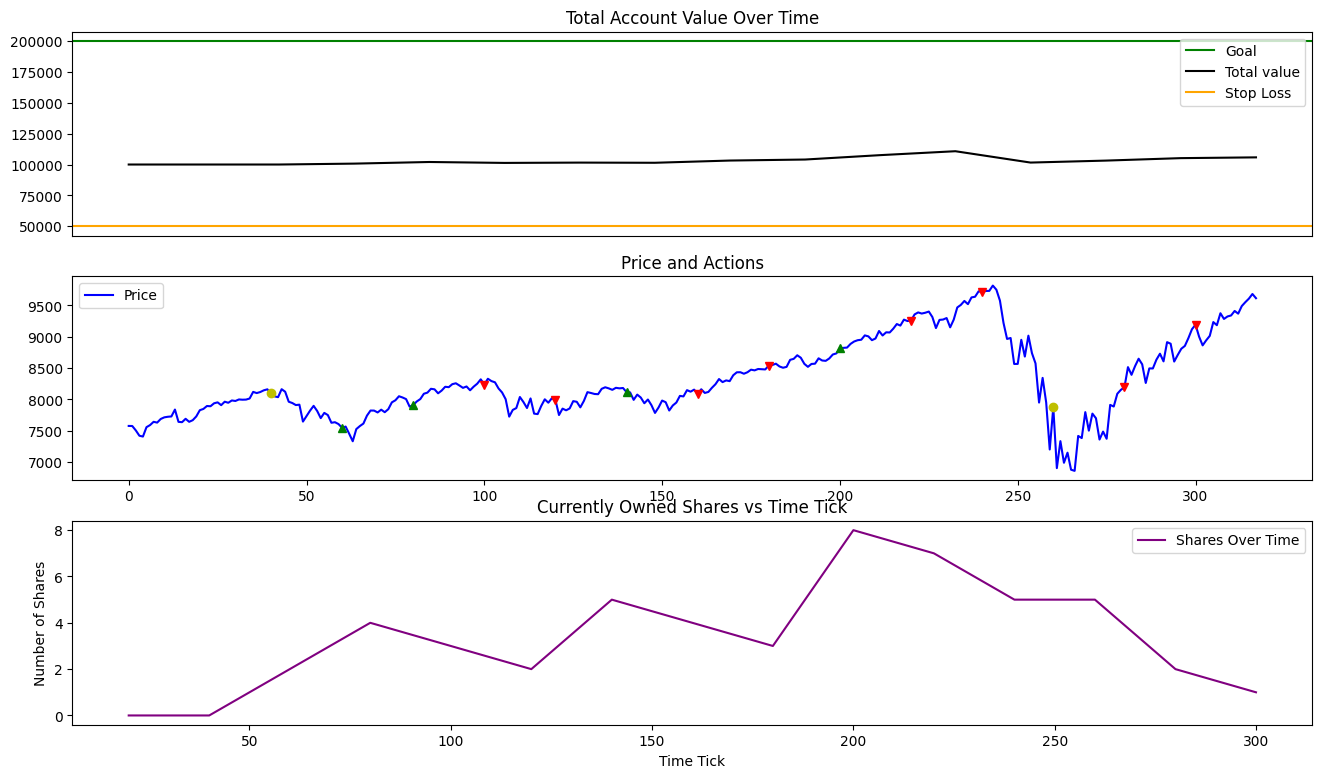

105787.89697265625

In [10]:
def demo():

    # Initialize the testing environment
    test_env = TradingEnv(
        data_frames=NASDAQ_TEST,
        window_size=20,
        render_mode="huma",
        start=100000,
        goal=200000,
        stop_loss_limit=50000,
        max_shares_per_trade=5,
    )
    agent = DQNAgent.load_model("./model", test_env.unwrapped)

    # Run a single episode for testing
    max_episodes = 1
    for episode in tqdm(range(max_episodes), desc="Test Model"):
        state_tuple = test_env.reset()
        current_state_array = state_tuple[0]
        current_state = np.reshape(current_state_array, [1, -1])

        while True:
            action = agent.compute_action(current_state)
            next_state_tuple, reward, terminated, truncated, info = test_env.step(action)
            next_state_array = next_state_tuple
            next_state = np.reshape(next_state_array, [1, -1])

            agent.store_episode(current_state, action, reward, next_state, terminated)
            current_state = next_state

            if terminated or truncated:
                agent.update_exploration_probability()
                break

    # Close the testing environment and render the test result
    test_env.close()
    test_env.render_final_result()
    return test_env.history["account_total"][-1]

demo()